# LAST MILE CONNECTIVITY OF NYC MTA STATIONS 

In [1]:
from sqlalchemy import create_engine
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from urllib.request import urlopen
import json
import folium

%matplotlib inline


/Users/aanvigoel/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#Importing the MTA Turnstile data for 2022 from MTA database downloaded from http://web.mta.info/developers/turnstile.html
#Creating SQLAlchemy Engine to read in .db a to a pandas database

engine = create_engine("sqlite:///mta_data.db")
engine.table_names()

# Create pandas dataframe 
mta_data = pd.read_sql('SELECT * FROM mta_data;', engine)


/var/folders/zd/hcr0j8s10c52wqddtzbkj5kr0000gn/T/ipykernel_25817/702444732.py:5: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


In [3]:
mta_data.head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/25/2022,00:00:00,REGULAR,7729818,2718760
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/25/2022,04:00:00,REGULAR,7729828,2718769
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/25/2022,08:00:00,REGULAR,7729835,2718793
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/25/2022,12:00:00,REGULAR,7729863,2718853
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/25/2022,16:00:00,REGULAR,7729932,2718904


### DATA CLEANING

In [4]:
#Checking if the data needs to be cleaned
mta_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5687284 entries, 0 to 5687283
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 477.3+ MB


In [5]:
mta_data.DATE.value_counts().sort_index()


01/01/2022    30079
01/02/2022    29905
01/03/2022    29913
01/04/2022    30000
01/05/2022    30009
              ...  
12/27/2021    29941
12/28/2021    30241
12/29/2021    30005
12/30/2021    30130
12/31/2021    29943
Name: DATE, Length: 189, dtype: int64

In [6]:
#As we also have data from Dec 2021 as part of the data files pulled from the Jan 2022 logs, 
#we'll need to filter out only 2022 data. But before we filter, we need to convert the Date and Time columns
#to Datetime format

mta_data["DATE"]=pd.to_datetime(mta_data['DATE'])
mta_data["TIME"]=pd.to_datetime(mta_data['TIME']).dt.time
mta_data = mta_data[mta_data.DATE.dt.year==2022]


In [7]:
mta_data.DATE.value_counts().sort_index()
#Now we can only see Dates starting form 01/01/2022


2022-01-01    30079
2022-01-02    29905
2022-01-03    29913
2022-01-04    30000
2022-01-05    30009
              ...  
2022-06-27    30364
2022-06-28    30267
2022-06-29    30272
2022-06-30    30185
2022-07-01    30117
Name: DATE, Length: 182, dtype: int64

In [8]:
#Dropping rows with duplicates and REGULR AUD data from the dataframe
mta_data.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], 
                          inplace=True, ascending=True)
mta_data.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE","TIME"], inplace=True)
mta_data = mta_data[mta_data['DESC']!='REGULR AUD']


In [9]:
mta_data = mta_data.drop(["DESC"], axis=1, errors="ignore")


In [10]:
mta_data.reset_index()
mta_data.shape


(5476877, 10)

## ANALYZING EXIT DATA - 
To analyze the last mile connectivity within NYC, we need to understand which mta stations are least popular destination stations for the commuters. We will use the MTA Turnstile db to look at the maximum average Exits per Station for 2022


In [11]:
mta_daily_exits = mta_data.groupby(['C/A','UNIT','SCP','STATION','DATE'],as_index=False)['EXITS'].first()


In [12]:
mta_daily_exits.head()


,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,2022-01-01,2649548
1,A002,R051,02-00-00,59 ST,2022-01-02,2649670
2,A002,R051,02-00-00,59 ST,2022-01-03,2649834
3,A002,R051,02-00-00,59 ST,2022-01-04,2650236
4,A002,R051,02-00-00,59 ST,2022-01-05,2650664


In [13]:
#On analyzing the turnstile data, we  see that we have cummulative values in the EXITS columns. 
#To get a better understanding of the Exit trends, we would need to find the daily counts for Exits instead of cummulative

mta_daily_exits[['PREV_DATE','PREV_EXIT']]=mta_daily_exits.groupby(['C/A','UNIT','SCP','STATION'])['DATE','EXITS'].apply(lambda grp:grp.shift(1))
mta_daily_exits.dropna(subset=['PREV_EXIT'],inplace=True)


/var/folders/zd/hcr0j8s10c52wqddtzbkj5kr0000gn/T/ipykernel_25817/2223414751.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily_exits[['PREV_DATE','PREV_EXIT']]=mta_daily_exits.groupby(['C/A','UNIT','SCP','STATION'])['DATE','EXITS'].apply(lambda grp:grp.shift(1))


In [14]:
mta_daily_exits['DAILY_EXITS']=mta_daily_exits['EXITS']-mta_daily_exits['PREV_EXIT']


In [15]:
#Checking for anomalies
mta_daily_exits.DAILY_EXITS.describe()


count    9.085790e+05
mean     1.280728e+03
std      4.879000e+06
min     -2.061816e+09
25%      9.300000e+01
50%      3.180000e+02
75%      7.170000e+02
max      1.871702e+09
Name: DAILY_EXITS, dtype: float64

In [16]:
#mta_daily_exits[mta_daily_exits['EXITS']<mta_daily_exits['PREV_EXIT']].head()
mta_daily_exits[mta_daily_exits['EXITS']<mta_daily_exits['PREV_EXIT']].shape


(5987, 9)

In [17]:
#mta_daily_exits[mta_daily_exits['DAILY_EXITS']>5000].head()
mta_daily_exits[mta_daily_exits['DAILY_EXITS']>5000].shape


(482, 9)

In [18]:
#Based on the above data there are 2 anomalies - 1) Negative counters 2) Counter overflow 

#Taking the abs of DAILIY EXIT values for the turnstiles that are counting in reverse 
mta_daily_exits['DAILY_EXITS']=abs(mta_daily_exits.DAILY_EXITS)

#Since the numbers of rows with counter overflow is relatively low, I have decided to drop the rows with counts>5000
mta_daily_exits=mta_daily_exits[mta_daily_exits.DAILY_EXITS < 5000]

mta_daily_exits.DAILY_EXITS.describe()


count    907767.000000
mean        515.840603
std         595.605357
min           0.000000
25%          97.000000
50%         322.000000
75%         722.000000
max        4999.000000
Name: DAILY_EXITS, dtype: float64

In [19]:
#There are 2 stations for the Tram between Manhattan and Roosevelt Island. We'll also remove these two rows. 
tram=mta_daily_exits['C/A'].isin(['TRAM1','TRAM2'])
mta_daily_exits=mta_daily_exits[~tram]


In [20]:
# Now we need to start looking at the Exit data for each Station 
station_daily = mta_daily_exits.groupby(['STATION','DATE'])['DAILY_EXITS'].sum().reset_index()


In [21]:
#Let's add the Day column to analyze station stats based on day of the week   
station_daily['DAY']=station_daily['DATE'].dt.dayofweek
station_daily.head()


,STATION,DATE,DAILY_EXITS,DAY
0,1 AV,2022-01-02,7264.0,6
1,1 AV,2022-01-03,8822.0,0
2,1 AV,2022-01-04,12999.0,1
3,1 AV,2022-01-05,13515.0,2
4,1 AV,2022-01-06,13820.0,3


### Getting the most popular and least popular stations:
Below are the most and least exited stations for 2022 data till date. 

In [22]:
station_to_date = station_daily.groupby(['STATION'])['DAILY_EXITS'].sum().reset_index()
station_to_date.sort_values('DAILY_EXITS', ascending=False, inplace=True)


In [23]:
most_popular_stations=station_to_date['STATION'][0:10]
most_popular_stations


61      34 ST-PENN STA
233    GRD CNTRL-42 ST
59     34 ST-HERALD SQ
14      14 ST-UNION SQ
351     TIMES SQ-42 ST
110              86 ST
46               23 ST
68     42 ST-PORT AUTH
226          FULTON ST
9               125 ST
Name: STATION, dtype: object

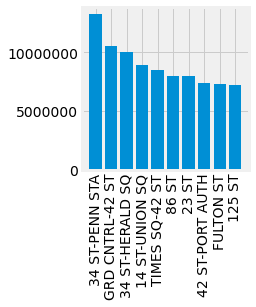

In [24]:
plt.figure(figsize=(3, 3))
plt.style.use('fivethirtyeight')
plt.bar(x=station_to_date['STATION'][:10], height=station_to_date['DAILY_EXITS'][:10])
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')

In [25]:
#The number of Daily Exits for the last three rows are too few to suspect error with the counter 
station_to_date = station_to_date.drop(station_to_date.tail(3).index)


In [26]:
least_popular_stations=station_to_date['STATION'][-10:] 
least_popular_stations

126        ATLANTIC AV
128           AVENUE I
140      BAYCHESTER AV
43              215 ST
292         NEPTUNE AV
148        BEACH 98 ST
49              238 ST
141       BEACH 105 ST
121    AQUEDUCT RACETR
162      BROAD CHANNEL
Name: STATION, dtype: object

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

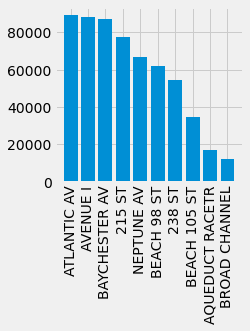

In [27]:
plt.figure(figsize=(3, 3))
plt.style.use('fivethirtyeight')
plt.bar(x=station_to_date['STATION'][-10:], height=station_to_date['DAILY_EXITS'][-10:])
plt.xticks(rotation=90)


### Exit Data based on Day of the Week 

In [28]:
station_by_day = station_daily.groupby(['STATION','DAY'])['DAILY_EXITS'].sum().reset_index()


### Visualizing the data 

In [29]:
#Extract data to focus only on the Top 5 stations 
station_plt = station_by_day[(station_by_day['STATION'].isin(least_popular_stations))]


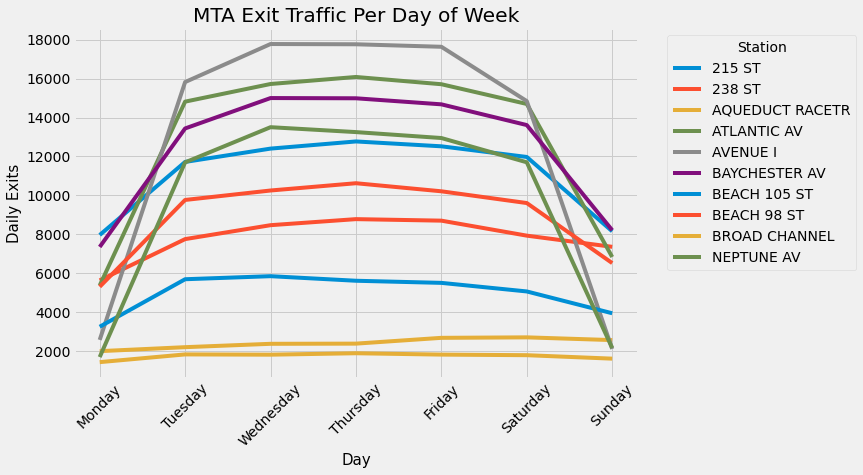

In [30]:
day_sequence=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.figure(figsize=(9,6))
for i, group in station_plt.groupby('STATION'):
    plt.plot(group['DAY'], group['DAILY_EXITS'],label=i)
    
plt.title("MTA Exit Traffic Per Day of Week")
plt.ylabel("Daily Exits", fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.legend(bbox_to_anchor=(1.40, 1.0), title="Station")
plt.xticks(np.arange(7),day_sequence, rotation='45')

plt.savefig('traffic_based_on_day.jpg')


### Getting Station locations

In [31]:
station_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')


In [32]:
station_loc_data = station_df[["Stop Name","Division","GTFS Latitude", "GTFS Longitude"]]
station_loc_data.rename(columns={'Stop Name':'STOP_NAME', 'Division':'DIVISION','GTFS Latitude':'LAT', 'GTFS Longitude':'LONG'}, inplace=True)

/var/folders/zd/hcr0j8s10c52wqddtzbkj5kr0000gn/T/ipykernel_25817/2931296924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_loc_data.rename(columns={'Stop Name':'STOP_NAME', 'Division':'DIVISION','GTFS Latitude':'LAT', 'GTFS Longitude':'LONG'}, inplace=True)


In [33]:
station_loc_data.sort_values('STOP_NAME')
station_loc_data.STOP_NAME = station_loc_data.STOP_NAME.str.upper()
station_loc_data.head()


/var/folders/zd/hcr0j8s10c52wqddtzbkj5kr0000gn/T/ipykernel_25817/2948292643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_loc_data.STOP_NAME = station_loc_data.STOP_NAME.str.upper()


,STOP_NAME,DIVISION,LAT,LONG
0,ASTORIA-DITMARS BLVD,BMT,40.775036,-73.912034
1,ASTORIA BLVD,BMT,40.770258,-73.917843
2,30 AV,BMT,40.766779,-73.921479
3,BROADWAY,BMT,40.761820,-73.925508
4,36 AV,BMT,40.756804,-73.929575


In [34]:
#Use FuzzyWuzzy to find identify matches for Station names between the mta db and the station location db
#Based on the guide here: https://www.geeksforgeeks.org/how-to-do-fuzzy-matching-on-pandas-dataframe-column-using-python/

match1 = []
match2 = []
p= []
list1 = station_to_date.STATION.tolist()
list2 = station_loc_data.STOP_NAME.tolist()

threshold = 50

for i in list1:
    match1.append(process.extractOne(i, list2, scorer=fuzz.ratio))
station_to_date['MATCHES'] = match1

for j in station_to_date['MATCHES']:
    if j[1] >= threshold:
        p.append(j[0])
            
    match2.append(','.join(p))
    p= []
    
station_to_date['MATCHES'] = match2


In [35]:
station_to_date.tail(10)

,STATION,DAILY_EXITS,MATCHES
126,ATLANTIC AV,89229.0,ATLANTIC AV
128,AVENUE I,88516.0,AVENUE I
140,BAYCHESTER AV,87272.0,BAYCHESTER AV
43,215 ST,77492.0,215 ST
292,NEPTUNE AV,66925.0,NEPTUNE AV
148,BEACH 98 ST,62257.0,BEACH 98 ST
49,238 ST,54595.0,238 ST
141,BEACH 105 ST,34875.0,BEACH 105 ST
121,AQUEDUCT RACETR,16850.0,AQUEDUCT RACETRACK
162,BROAD CHANNEL,12128.0,BROAD CHANNEL


In [36]:
#Join the two db tables to get station name and coordinates in a single df
map_loc= pd.merge(station_to_date, right=station_loc_data, left_on='MATCHES', right_on='STOP_NAME',how='left')
map_loc=map_loc.dropna()
map_loc=map_loc.drop_duplicates(subset='STATION').reset_index(drop=True)


In [37]:
map_loc_top=map_loc[0:10]   #List of most popular station locations
map_loc_bottom=map_loc[-10:]    #List of least popular station locations

map_loc_bottom.head()

,STATION,DAILY_EXITS,MATCHES,STOP_NAME,DIVISION,LAT,LONG
359,ATLANTIC AV,89229.0,ATLANTIC AV,ATLANTIC AV,BMT,40.675345,-73.903097
360,AVENUE I,88516.0,AVENUE I,AVENUE I,IND,40.625322,-73.976127
361,BAYCHESTER AV,87272.0,BAYCHESTER AV,BAYCHESTER AV,IRT,40.878663,-73.838591
362,215 ST,77492.0,215 ST,215 ST,IRT,40.869444,-73.915279
363,NEPTUNE AV,66925.0,NEPTUNE AV,NEPTUNE AV,IND,40.581011,-73.974574


### Citi Bike Data

In [38]:
#Loading the JSON file with the citi bike data 

url ='https://gbfs.citibikenyc.com/gbfs/en/station_information.json'
response = urlopen(url)
cb_json = json.loads(response.read())

cb_data = pd.json_normalize(cb_json['data'], record_path=['stations'])

cb_data=cb_data[['name','lat','lon']]

In [39]:
#To find the nearest Citi bike racks from the MTA stations, 
#we will need to calculate the distances between the stations and the bike racks

import haversine as hs
from haversine import Unit

def get_distances(df1, df2):
    dist_df=pd.DataFrame()
    
    for i,row1 in df1.iterrows():
        for j,row2 in df2.iterrows():
            loc1 = [row1['LAT'], row1['LONG']]
            loc2 = [row2['lat'], row2['lon']]
            
            dist= hs.haversine(loc1,loc2, unit=Unit.MILES)
            df2.at[j,'dist']=dist
            df2.at[j,'station_name'] = row1['STATION']
            
        dist_append= df2.sort_values(by=['dist'])[0:3]
        dist_df=pd.concat([dist_df,dist_append], ignore_index=True)
        
        
    return dist_df

In [40]:
#Get a list of all stations with the min distances>1 mile -> This will take some time to run 
all_distances = get_distances(map_loc, cb_data)


In [41]:
all_distances['dist'].describe()

count    1107.000000
mean        1.046115
std         1.770816
min         0.001342
25%         0.105600
50%         0.172126
75%         1.271447
max         9.600985
Name: dist, dtype: float64

In [42]:
all_distances = all_distances.sort_values(by=['dist'], ascending=False).reset_index(drop=True)

In [43]:
all_distances.head()

,name,lat,lon,dist,station_name
0,Bushwick Ave & Furman Ave,40.68281,-73.90623,9.600985,FAR ROCKAWAY
1,Broadway & Furman Ave,40.68139,-73.90756,9.504291,BEACH 25 ST
2,Broadway & Furman Ave,40.68139,-73.90756,9.418514,BEACH 36 ST
3,Somers St & Broadway,40.67945,-73.90474,9.406285,FAR ROCKAWAY
4,Van Sinderen Ave & Truxton St,40.67860,-73.90369,9.327973,FAR ROCKAWAY


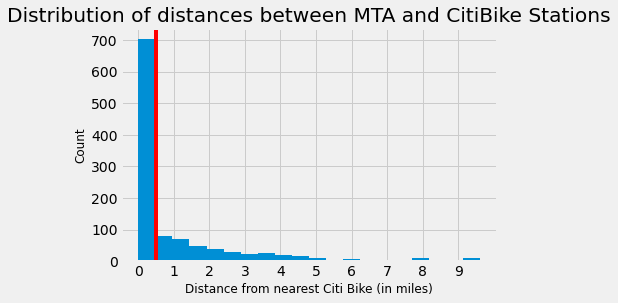

In [44]:
# Distribution of the min distances between all the MTA stations and their closest Citi bike racks 
plt.hist(all_distances['dist'], bins=20)
plt.xlabel('Distance from nearest Citi Bike (in miles)', fontsize='12')
plt.ylabel('Count', fontsize='12')
plt.xticks(np.arange(0,10,1))
plt.title('Distribution of distances between MTA and CitiBike Stations', ha='center')
plt.axvline(0.5, color='r')

In [45]:
bottom_distances = get_distances(map_loc_bottom, cb_data)
bottom_distances.head()

,name,lat,lon,dist,station_name
0,Van Sinderen Ave & Truxton St,40.678600,-73.903690,0.227036,ATLANTIC AV
1,Somers St & Broadway,40.679450,-73.904740,0.296407,ATLANTIC AV
2,Broadway & Furman Ave,40.681390,-73.907560,0.478683,ATLANTIC AV
3,Church Ave & Story St,40.642031,-73.981073,1.183252,AVENUE I
4,Church Ave & McDonald Ave,40.642809,-73.979239,1.219205,AVENUE I


In [46]:
#Using Folium to visualize the station and bike rack locations
#https://python-visualization.github.io/folium/quickstart.html

m_bottom = folium.Map(location=[40.7128,-74.0060], zoom_start=10.45, tiles="cartodbpositron")

stationLayer = folium.FeatureGroup(name="Station Locations").add_to(m_bottom)
radiusLayer = folium.FeatureGroup(name="Station Radius").add_to(m_bottom)
bikeLayer = folium.FeatureGroup(name="Citi Bike Racks").add_to(m_bottom)

for i, row in map_loc_bottom.iterrows():    
    folium.Marker(
        location=[row['LAT'], row['LONG']],
        popup=row['STATION'],
        icon=folium.Icon(color="green"),
    ).add_to(stationLayer)
    
    folium.Circle(
        location=[row['LAT'], row['LONG']],
        popup=row['STATION'],
        radius=1609,
        color="green",
        fill=True,
        fill_color="green",
    ).add_to(radiusLayer)
    
for i, row in bottom_distances.iterrows():    

    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['name'],
        icon=folium.Icon(color="blue"),
    ).add_to(bikeLayer)

    
folium.LayerControl().add_to(m_bottom)
m_bottom

### Comparing with data from most popular Exits Stations

In [47]:
top_distances = get_distances(map_loc_top, cb_data)
top_distances.head()

,name,lat,lon,dist,station_name
0,W 35 St & 8 Ave,40.752762,-73.992805,0.044940,34 ST-PENN STA
1,8 Ave & W 33 St,40.751551,-73.993934,0.058256,34 ST-PENN STA
2,8 Ave & W 31 St,40.750585,-73.994685,0.135681,34 ST-PENN STA
3,E 40 St & Park Ave,40.750756,-73.978326,0.104649,GRD CNTRL-42 ST
4,E 44 St & Lexington Ave,40.752643,-73.974996,0.113952,GRD CNTRL-42 ST


In [48]:
#Using Folium to visualize the station locations

m_top = folium.Map(location=[40.7128,-74.0060], zoom_start=11, tiles="cartodbpositron")

stationLayer = folium.FeatureGroup(name="Station Locations").add_to(m_top)
radiusLayer = folium.FeatureGroup(name="Station Radius").add_to(m_top)
bikeLayer = folium.FeatureGroup(name="Citi Bike Racks").add_to(m_top)

for i, row in map_loc_top.iterrows():    
    folium.Marker(
        location=[row['LAT'], row['LONG']],
        popup=row['STATION'],
        icon=folium.Icon(color="orange"),
    ).add_to(stationLayer)
    
    folium.Circle(
        location=[row['LAT'], row['LONG']],
        popup=row['STATION'],
        radius=804,
        color="orange",
        fill=True,
        fill_color="orange",
    ).add_to(radiusLayer)
    
for i, row in top_distances.iterrows():    
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['name'],
        icon=folium.Icon(color="blue"),
    ).add_to(bikeLayer)
    
folium.LayerControl().add_to(m_top)
m_top